# Kamień milowy 5 - Model obrazowy

W modelu zostały wykorzystane bazy danych:
- ZhangLabData
- siim_train_test

In [1]:
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt
import pydicom,os,cv2
from glob import glob
from tqdm import tqdm
import seaborn as sns
import tensorflow as tf
from PIL import Image
import pydicom
%matplotlib inline

import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

#### Najpierw zapisujemy wszystkie zdjęcia w ramce
W celu przyporządkowania naszych zdjęć do odpowiednich folderów musimy mieć informacje na temat czy dane zdjęcie przedstawia osobę chorą czy zdrową. Aby dostać się do informacji na ten temat stworzymy tabelkę z odczytem informacji z formatu DICOM, a następnie dzięki tej informacji będziemy mogli "wysłać" zdjęcie do odpowiedniego folderu.


In [2]:
train_fns = sorted(glob('C:/Users/maaja/Desktop/AndrzejczukMaja/archive/siim/dicom-images-train/*/*/*.dcm'))
test_fns = sorted(glob('C:/Users/maaja/Desktop/AndrzejczukMaja/archive/siim/dicom-images-test/*/*/*.dcm'))

In [3]:
df = pd.read_csv('C:/Users/maaja/Desktop/AndrzejczukMaja/archive/siim/train-rle.csv')

Tworzenie ramki:

In [5]:
missing = 0
multiple = 0
patients_data = []
for k,paths in enumerate(train_fns):
    patient = {}
    img_id = paths.split('\\')[-1]
    data = pydicom.dcmread(paths)
    try:
        tmp = df[df['ImageId'] == '.'.join(img_id.split('.')[:-1])]
        
        if tmp.shape[0] > 1: 
            multiple += 1
        rle = tmp[' EncodedPixels'].values
        if rle[0] == '-1':
            pixels = rle[0]
        else:    
            pixels = [i for i in rle]
        
        patient["UID"] = data.SOPInstanceUID
        patient['EncodedPixels'] = pixels
        patient["Age"] = data.PatientAge
        patient["Sex"] = data.PatientSex
        patient["Modality"] = data.Modality
        patient["BodyPart"] = data.BodyPartExamined
        patient["ViewPosition"] = data.ViewPosition
        patient["filepath"] = paths
        patients_data.append(patient)
    except:
        missing += 1

In [6]:
df_patients = pd.DataFrame(patients_data, columns=["UID", "EncodedPixels", "Age", 
                            "Sex", "Modality", "BodyPart", "ViewPosition", "filepath"])

df_patients['Pneumothorax'] = df_patients['EncodedPixels'].apply(lambda x:0 if x == '-1' else 1)
df_patients['Pneumothorax'] = df_patients['Pneumothorax'].astype('int')
df_patients.head() 

,UID,EncodedPixels,Age,Sex,Modality,BodyPart,ViewPosition,filepath,Pneumothorax
0,1.2.276.0.7230010.3.1.4.8323329.1000.151787516...,-1,38,M,CR,CHEST,PA,C:/Users/maaja/Desktop/AndrzejczukMaja/archive...,0
1,1.2.276.0.7230010.3.1.4.8323329.10000.15178752...,-1,10,F,CR,CHEST,AP,C:/Users/maaja/Desktop/AndrzejczukMaja/archive...,0
2,1.2.276.0.7230010.3.1.4.8323329.10001.15178752...,-1,50,F,CR,CHEST,AP,C:/Users/maaja/Desktop/AndrzejczukMaja/archive...,0
3,1.2.276.0.7230010.3.1.4.8323329.10002.15178752...,-1,68,F,CR,CHEST,AP,C:/Users/maaja/Desktop/AndrzejczukMaja/archive...,0
4,1.2.276.0.7230010.3.1.4.8323329.10003.15178752...,-1,65,M,CR,CHEST,AP,C:/Users/maaja/Desktop/AndrzejczukMaja/archive...,0


Funkcja zmieniająca obiekt DICOM na zdjęcie

In [7]:
def path_to_image(path):
    name, extension = os.path.splitext(path)
    if extension == '.dcm':
        try:
            ds = pydicom.dcmread(path)
            array = ds.pixel_array
            img = Image.fromarray(array)
        except:
            pass
    else:
        img = Image.open(path)
    return img

Łącze bazy danych wrzucając do stworzonych folderów dla bazy ZhangLab zdjęcia z bazy siim. Zauważyliśmy, że zdjęcia w bazie Zhang są podzielone tak, że około 10.6% zdjęć z bazy jest folderem testowym. Dlategoteż w ten sam sposób podzieliliśmy dodane zdjęcia z bazy siim_train_test, aby stosunek między pacjentami zdrowymi a pacjentami chorymi był mniej więcej taki sam w folderze treningowym i testowym.

In [10]:
image_no = 100001

for i in range(6000):    
    path = df_patients["filepath"][i]
    healthy = df_patients["Pneumothorax"][i]
    if i < 5364:
        if healthy == 0:
            img2 = path_to_image(path)
            name = (r'C:\Users\maaja\Desktop\Baza2\chest_xray\train\NORMAL\zdj'+ str(image_no) + '.jpg')
            img2.save(name, 'JPEG') 
            image_no += 1
        else:
            img2 = path_to_image(path)
            name = (r'C:\Users\maaja\Desktop\Baza2\chest_xray\train\PNEUMONIA\zdj'+ str(image_no) + '.jpg')
            img2.save(name, 'JPEG') 
            image_no += 1
    else:
        if healthy == 0:
            img2 = path_to_image(path)
            name = (r'C:\Users\maaja\Desktop\Baza2\chest_xray\test\NORMAL\zdj'+ str(image_no) + '.jpg')
            img2.save(name, 'JPEG') 
            image_no += 1
        else:
            img2 = path_to_image(path)
            name = (r'C:\Users\maaja\Desktop\Baza2\chest_xray\test\PNEUMONIA\zdj'+ str(image_no) + '.jpg')
            img2.save(name, 'JPEG') 
            image_no += 1
        


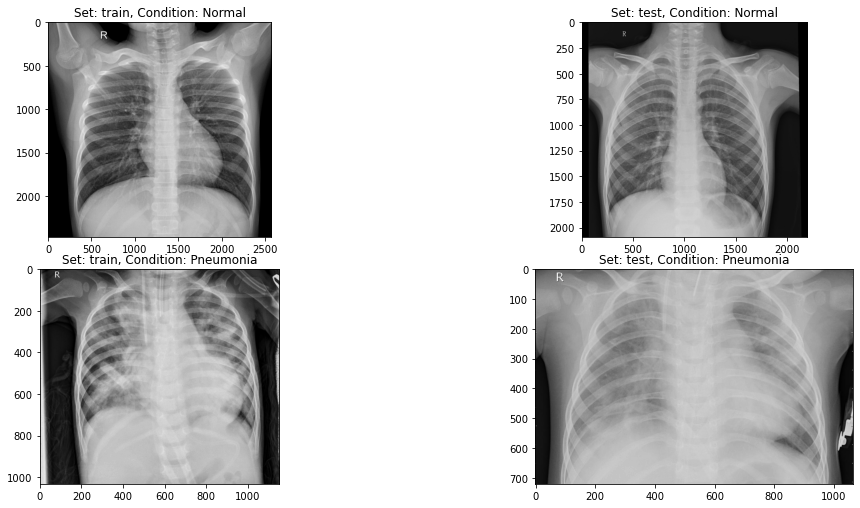

In [11]:
input_path = 'C:/Users/maaja/Desktop/Baza2/chest_xray/'

fig, ax = plt.subplots(2, 2, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'test']):
    set_path = input_path+_set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+2].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    ax[i+2].set_title('Set: {}, Condition: Pneumonia'.format(_set))

In [12]:
for _set in ['train', 'test']:
    n_normal = len(os.listdir(input_path + _set + '/NORMAL'))
    n_infect = len(os.listdir(input_path + _set + '/PNEUMONIA'))
    print('Set: {}, normal images: {}, pneumonia images: {}'.format(_set, n_normal, n_infect))

Set: train, normal images: 5521, pneumonia images: 5075
Set: test, normal images: 740, pneumonia images: 520


In [13]:
def process_data(img_dims, batch_size):
    # Data generation objects
    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
    test_val_datagen = ImageDataGenerator(rescale=1./255)
    
    # This is fed to the network in the specified batch sizes and image dimensions
    train_gen = train_datagen.flow_from_directory(
    directory=input_path+'train', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)

    test_gen = test_val_datagen.flow_from_directory(
    directory=input_path+'test', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)
    
    # I will be making predictions off of the test set in one batch size
    # This is useful to be able to get the confusion matrix
    test_data = []
    test_labels = []

    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(input_path + 'test' + cond)):
            img = plt.imread(input_path+'test'+cond+img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/NORMAL/':
                label = 0
            elif cond=='/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_gen, test_gen, test_data, test_labels

In [14]:
img_dims = 150
epochs = 10
batch_size = 32

train_gen, test_gen, test_data, test_labels = process_data(img_dims, batch_size)

Found 10596 images belonging to 2 classes.
Found 1260 images belonging to 2 classes.


In [15]:
inputs = Input(shape=(img_dims, img_dims, 3))

# First conv block
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Second conv block
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Third conv block
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Fourth conv block
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Fifth conv block
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# FC layer
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Output layer
output = Dense(units=1, activation='sigmoid')(x)

# Creating model and compiling
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

In [16]:
hist = model.fit_generator(
           train_gen, steps_per_epoch=train_gen.samples // batch_size, 
           epochs=epochs, validation_data=test_gen, 
           validation_steps=test_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])

C:\Users\maaja\AppData\Local\Temp/ipykernel_2332/2276952013.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/10
331/331 [==============================] - 294s 885ms/step - loss: 0.5256 - accuracy: 0.7517 - val_loss: 1.2497 - val_accuracy: 0.4127 - lr: 0.0010
Epoch 2/10
331/331 [==============================] - 274s 827ms/step - loss: 0.4616 - accuracy: 0.8009 - val_loss: 0.5782 - val_accuracy: 0.6490 - lr: 0.0010
Epoch 3/10
331/331 [==============================] - ETA: 0s - loss: 0.4393 - accuracy: 0.8094
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
331/331 [==============================] - 267s 806ms/step - loss: 0.4393 - accuracy: 0.8094 - val_loss: 0.4269 - val_accuracy: 0.8285 - lr: 0.0010
Epoch 4/10
331/331 [==============================] - 249s 753ms/step - loss: 0.3982 - accuracy: 0.8300 - val_loss: 0.3655 - val_accuracy: 0.8518 - lr: 3.0000e-04
Epoch 5/10
331/331 [==============================] - ETA: 0s - loss: 0.3715 - accuracy: 0.8447
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
331/331 [==================

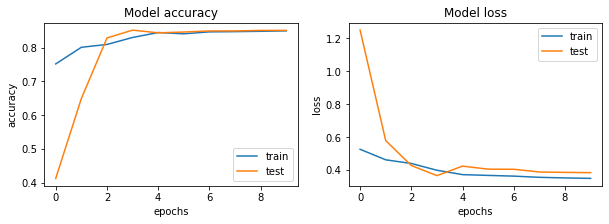

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'test'])

In [15]:

from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train accuracy: {}'.format(np.round((hist.history['accuracy'][-1])*100, 2)))

60/60 [==============================] - 8s 136ms/step
CONFUSION MATRIX ------------------
[[1170   69]
 [ 237  425]]

TEST METRICS ----------------------
Accuracy: 83.90320883745397%
Precision: 86.03238866396761%
Recall: 64.19939577039275%
F1-score: 73.52941176470588

TRAIN METRIC ----------------------
Train accuracy: 83.11


## Podsumowanie
W naszym modelu wykorzystaliśmy 2 bazy danych, które połączyliśmy wykorzystując foldery jednej z nich a następnie wczytując kolejne zdjęcia z drugiej ramki za pomocą przygotowanego przez nas kodu. Końcowo dzięki odpowiedniemu processingowi zdjęć udało nam się uzyskać satysfakcjonujące wyniki.

Link do strony, z której wykorzystaliśmy kod: https://towardsdatascience.com/deep-learning-for-detecting-pneumonia-from-x-ray-images-fc9a3d9fdba8